<a href="https://colab.research.google.com/github/mayukbasu/Titanic-Dataset/blob/main/Titanic_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates Titanic problem. I will try my best to illustrate all steps I used to solve the problem. However, solving a machine learning problem takes a lot of steps, including understanding the problem, cleaning the data, exploration data analysis, feature engineering, machine learning algorithms, model evaluation and selection, evaluation metrics, etc. Actually each step can be a standalone topic for further investigation.

# **Description**

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).


Train and Test Data

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

**Goal**

Goal is to predict if a passenger survived the sinking of the Titanic or not. For each in the test set, you must predict a 0 or 1 value for the variable.


**Metric**

Your score is the percentage of passengers you correctly predict. This is known as accuracy.


## Problem-Solving Process

Important: Although the problem-solving process presented here looks like a linear and waterfall style, it's actually really an iterative process, which means that you may need to go back and forth to make sure your previous hypothesis was correct, or you need to test whether your new idea really works.



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import collections

# allow IPython Notebook cell multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import csv

import warnings
warnings.filterwarnings('ignore')

Initialize plotting parameters

In [ ]:

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True

Helper functions

In [ ]:

def set_seaborn_plot_style(ax, xlabel, ylabel, font_size=14):
    ax.legend(loc='upper right', fontsize=14);
    ax.tick_params(axis="x", labelsize=font_size);
    ax.tick_params(axis="y", labelsize=font_size);
    ax.set_xlabel(xlabel, fontsize=font_size);
    ax.set_ylabel(ylabel, fontsize=font_size);

In [ ]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

print("Training dataset")
train_df

print("Testing dataset")
test_df

Training dataset


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Testing dataset


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


So, for the training dataset, there are 891 instances; while for the testing dataset, there are only 418 instances. Besides that, we can see that the training dataset has 12 columns(11 feature columns), since it has a label(Survived) for each instance. Now let's understand the training dataset further, such as inspect data type of each column, check if there is any null value, etc.

# More Information on Data: Data Types, Missing Values and several other

In [ ]:
print('training data')
train_df.info()

print()
print('tesitng data')
test_df.info()

training data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

tesitng data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-n

Since there are 891 entries in total, so Age, Cabin and Embarked columns have missing values(null). Besides, since this is a binary classification task, we need to make sure the labels really have two values only.(0 or 1)

In [ ]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's understand the meaning of each column in traning data deeper.

**Data Dictionary**

|Variable|Definition|Key|
|---|---|---|
|survival|Survivial|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings/spouses aboard the Titanic||
|parch|# of parents/children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**Variable Notes**

> Tip: Since the numbers below all have true meanings, so it's better to simply use regular numbers for encoding the features. If a feature doesn't have ordinal characteristics, then we can transfer numbers to the one-hot encoding format.


**pclass**: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them.

# Plotting for Easier Exploration

PassengerId

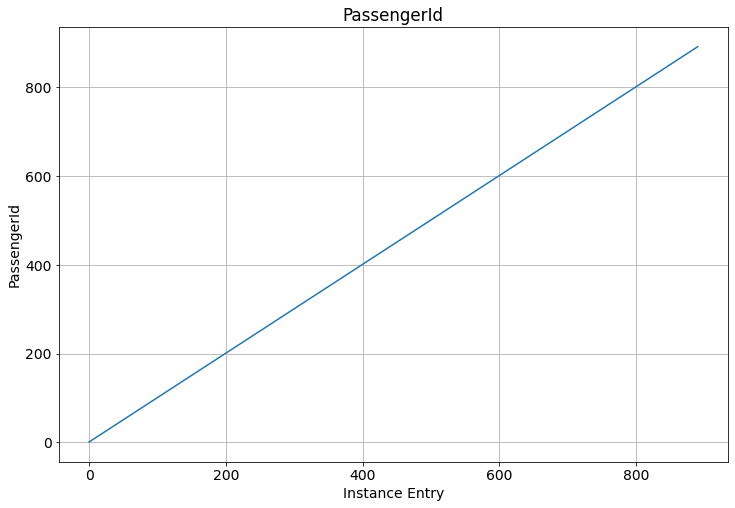

In [ ]:
plt.title('PassengerId');
plt.xlabel('Instance Entry');
plt.ylabel('PassengerId');
plt.plot(train_df['PassengerId']);

It should be a straight line

In [ ]:
assert collections.Counter(train_df['PassengerId']) == collections.Counter(range(1, 892)), 'PassengerId is not a straight line'

Pclass

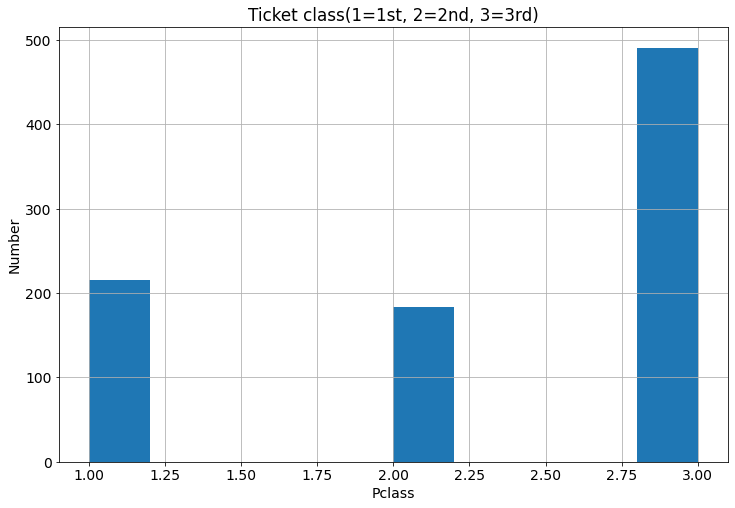

In [ ]:
plt.title('Ticket class(1=1st, 2=2nd, 3=3rd)');
plt.xlabel('Pclass');
plt.ylabel('Number');
plt.hist(train_df['Pclass']);

**Sex**

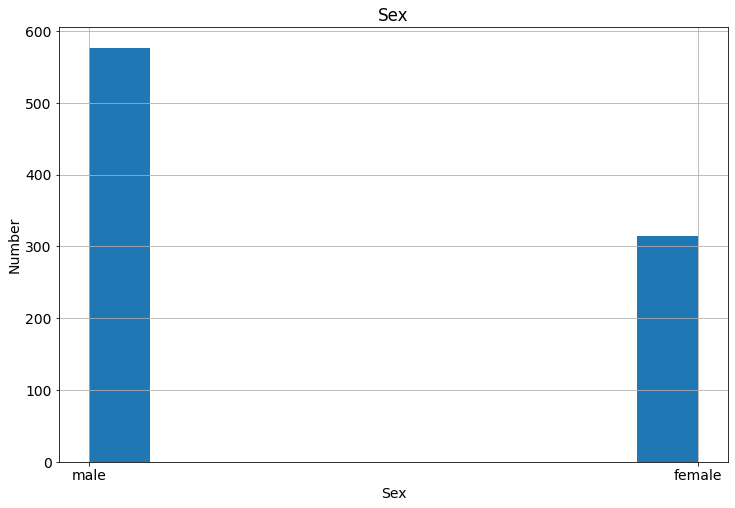

In [ ]:
plt.title('Sex');
plt.xlabel('Sex');
plt.ylabel('Number');
plt.hist(train_df['Sex']);

Age

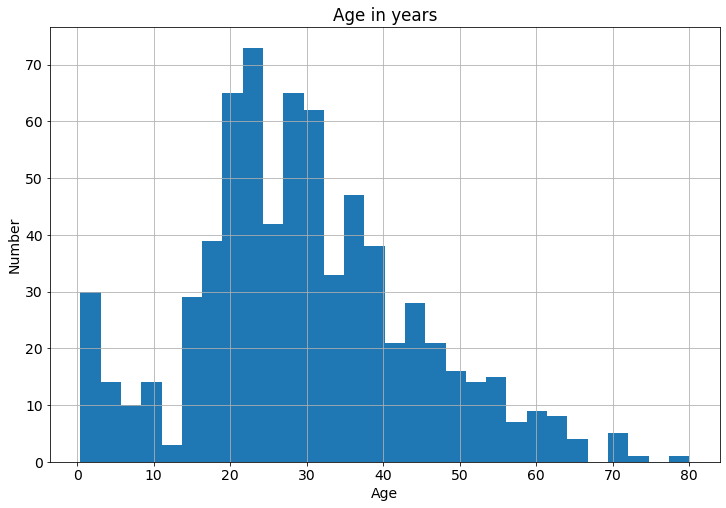

In [ ]:
plt.title('Age in years');
plt.xlabel('Age');
plt.ylabel('Number');
plt.hist(train_df['Age'].dropna(), bins=30);

Note: The Age column has 177(891-714) null values.

Sibsp

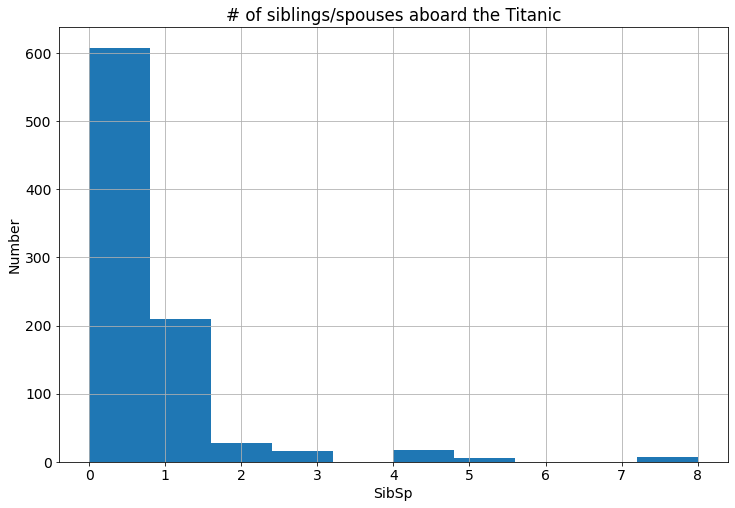

In [ ]:
plt.title('# of siblings/spouses aboard the Titanic');
plt.xlabel('SibSp');
plt.ylabel('Number');
plt.hist(train_df['SibSp']);

Parch

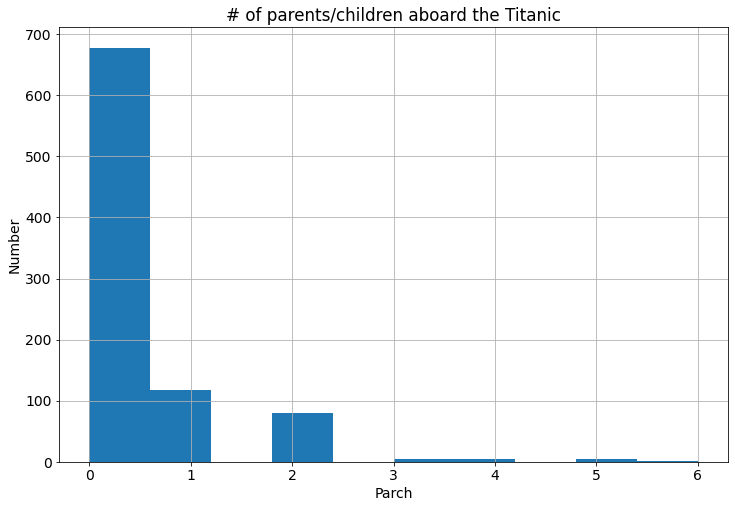

In [ ]:
plt.title('# of parents/children aboard the Titanic');
plt.xlabel('Parch');
plt.ylabel('Number');
plt.hist(train_df['Parch']);

Fare

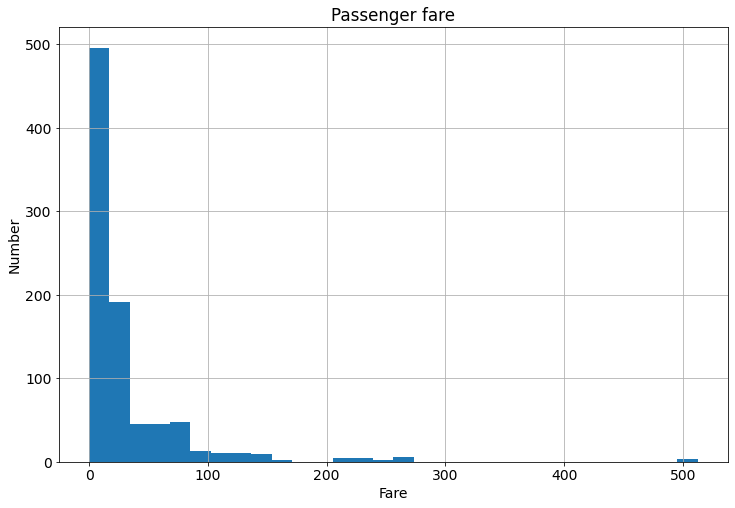

In [ ]:
plt.title('Passenger fare');
plt.xlabel('Fare');
plt.ylabel('Number');
plt.hist(train_df['Fare'], bins=30);

Embarked

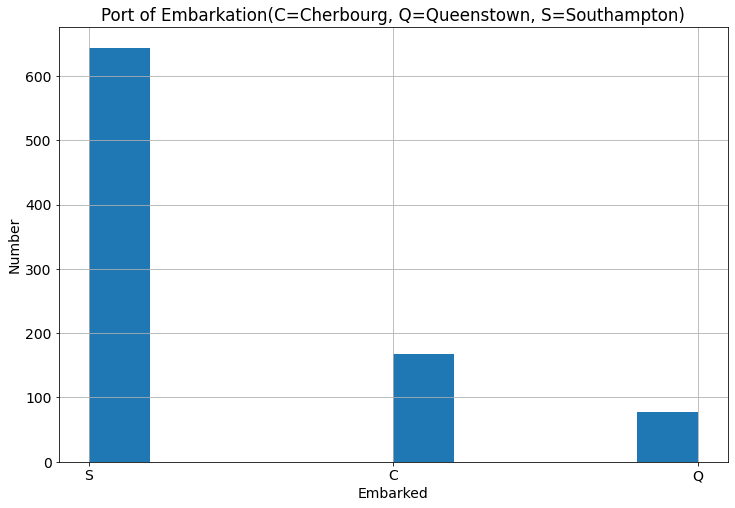

In [ ]:
plt.title('Port of Embarkation(C=Cherbourg, Q=Queenstown, S=Southampton)');
plt.xlabel('Embarked');
plt.ylabel('Number');
plt.hist(train_df['Embarked'].dropna());

**Correlation Plot**

After we inspect distributions of each feature column, now we are going to see the correlation plot among features and the label.

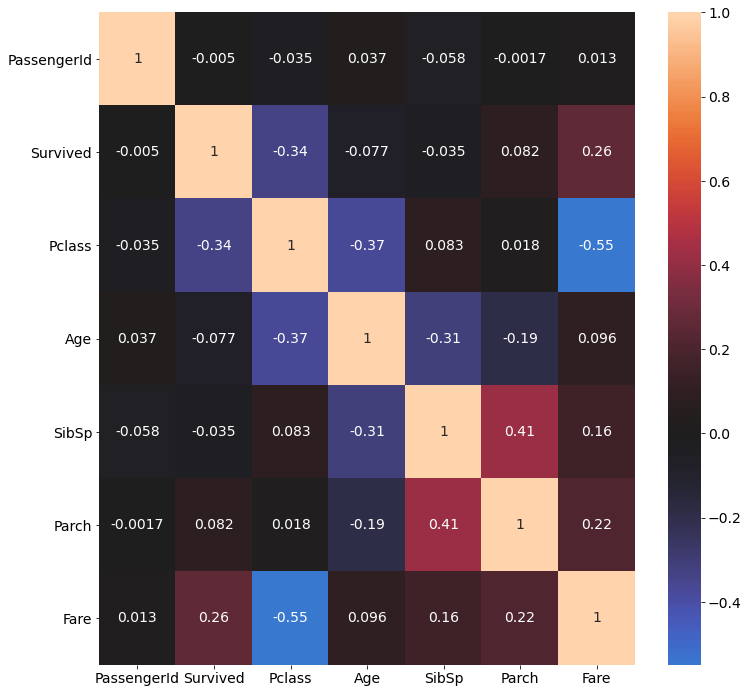

In [ ]:
plt.figure(figsize=(12, 12));
ax = sns.heatmap(train_df.corr(), annot=True, center=0);
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0);

Note: The Survived column is the label of the training dataset.

We can easily observe that no two columns are highly correlated with each other(like >0.7). Also, it makes sense that some features are a lot more correlated with some other features. For example, Pclass and Survived and Pclass and Fare. Now I want to further draw plots to understand more among these "highly-correlated" columns.

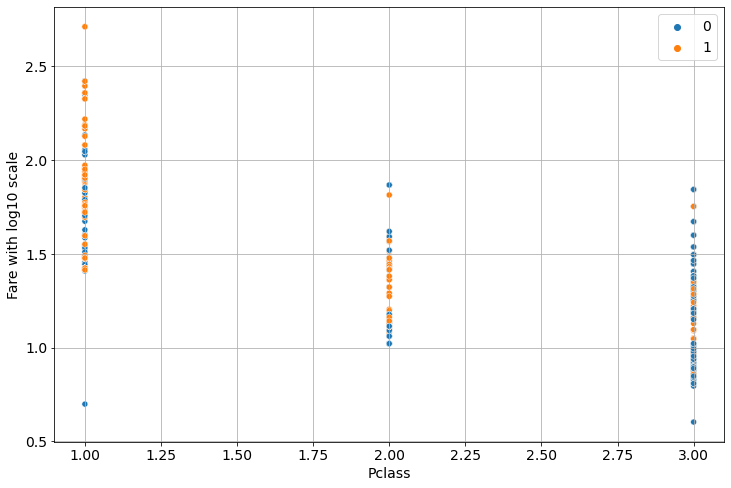

In [ ]:

xlabel = 'Pclass'
ylabel = 'Fare with log10 scale'
plt.figure(figsize=(12, 8));
ax = sns.scatterplot(x=train_df['Pclass'], y=np.log10(train_df['Fare']), hue=train_df['Survived']);
set_seaborn_plot_style(ax, xlabel, ylabel);

We can easily see that fare is much higher in the 1st class. However, there seems like an outlier point(blue) in the bottom left that we may need to investigate further.

Pclass vs. Age with Survived as hue

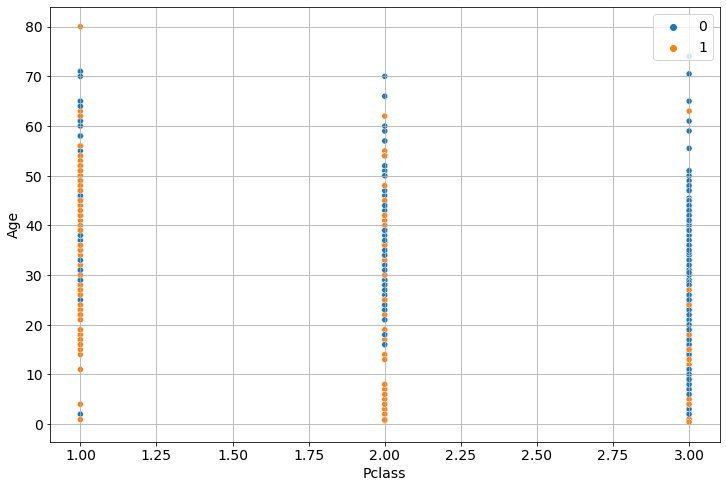

In [ ]:

xlabel = 'Pclass'
ylabel = 'Age'
plt.figure(figsize=(12, 8));
ax = sns.scatterplot(x='Pclass', y='Age', hue='Survived', data=train_df);
set_seaborn_plot_style(ax, xlabel, ylabel);

We can at least reach these conclusions:
- Most people who were survived are in the 1st class, and least people in the 3rd class were survived
- For survivers among all classes, the 1st class has the biggest spread
- For the 2nd and 3rd classes, most survivers are in the younger ages, especially for the 2nd class

Age vs. Fare with Survived as hue

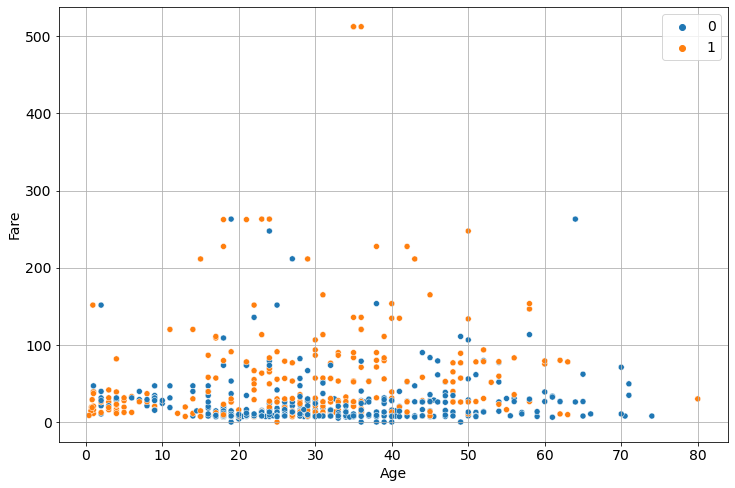

In [ ]:

xlabel='Age'
ylabel='Fare'
plt.figure(figsize=(12, 8));
ax = sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_df);
set_seaborn_plot_style(ax, xlabel, ylabel);

We can easily observe that more adults who had higher fare were survived than those who had lower fare.

## Feature Engineering

Since machine learning algorithms only take numerical data, so we need to make sure every feature has appropriate form before modeling. This process is called feature engineering, including some common operations like dealing with missing values, choosing appropriate features to feed into models, some mathematical transformation on features, encoding categorical feature columns, etc.

> Tip: What operations to take in feature engineering plays an important role in influencing model performance, so we need to choose appropriate operations based on what model we decide to use.

#### Choose appropriate features

There are two columns(Name, Ticket) with text features, and it's more complicated. So, I'll discard them first for the baseline model. The PassengerId column doesn't correlate with other featrues, I'll discard them as they look like doesn't have the true meaning.

In [ ]:

label = ['Survived']
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
train_df_ = train_df[features+label]
test_df_ = test_df[features]

print("training data")
train_df_
print("testing data")
test_df_

training data


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,NaN,S,0
1,1,female,38.0,1,0,71.2833,C85,C,1
2,3,female,26.0,0,0,7.9250,NaN,S,1
3,1,female,35.0,1,0,53.1000,C123,S,1
4,3,male,35.0,0,0,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,NaN,S,0
887,1,female,19.0,0,0,30.0000,B42,S,1
888,3,female,NaN,1,2,23.4500,NaN,S,0
889,1,male,26.0,0,0,30.0000,C148,C,1


testing data


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S
...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,NaN,S
414,1,female,39.0,0,0,108.9000,C105,C
415,3,male,38.5,0,0,7.2500,NaN,S
416,3,male,NaN,0,0,8.0500,NaN,S


#### Dealing with missing values

- Discard the column(if there are too many null values, or some critical information is missing)
- Discard the row(but this would make less training data)
- Imputation(with the mean, median, min, max, etc. value of other instances)

We inspect what columns have missing values first

In [ ]:

print("training data")
train_df_.info()

print()
print("testing data")
test_df_.info()

training data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB

testing data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  

We can see that the Cabin column has too many null values both in training and testing data, so I'll discard it.

In [ ]:
label = ['Survived']
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train_df_ = train_df[features+label]
test_df_ = test_df[features]

print("training data")
train_df_
print("testing data")
test_df_

training data


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0
...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,0
887,1,female,19.0,0,0,30.0000,S,1
888,3,female,NaN,1,2,23.4500,S,0
889,1,male,26.0,0,0,30.0000,C,1


testing data


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


For other columns that have missing values, We can use choose appropriate imputation techniques based on their distribution. Now, we simply choose the `most_frequent` strategy for brevity. Finally we make sure they don't have any missing values.

In [ ]:

label = ['Survived']
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dtypes = train_df_.dtypes
train_df_impute = pd.DataFrame(imp.fit_transform(train_df_[features]), columns=features)
train_df_ = pd.concat([train_df_impute, train_df_[label]], axis=1)
test_df_ = pd.DataFrame(imp.transform(test_df_), columns=features)

for i, feature in enumerate(features):
    train_df_[feature] = train_df_[feature].astype(dtypes[i])
    test_df_[feature] = test_df_[feature].astype(dtypes[i])

print("training data")
train_df_.info()

print()
print("testing data")
test_df_.info()

training data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    object 
 7   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB

testing data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64

#### Some mathematical transformations on features

- Normalization(make feature values between [0, 1])
- Standardization(with mean 0, vairance 1)
- Log-transformation(make feature values with smaller variation)

This part plays an important role in model performance, and it really depends on what model you choose. For example, if your model uses the "distance-based" algorithm like SGD or ridge regression, then standardization may help.

#### Encoding categorical feature columns

- One-hot encoding(if the column values don't have meaningful ordinal information)
- Ordinal numbers

It seems like the Embarked column should also take one-hot encoding format; however, I am curious if they actually correlate with other columns. If they are correlated with other columns, it makes more sense to have ordinal characteristics.

In [ ]:
embarked_mapping = {
    'S': 1,
    'C': 2,
    'Q': 3
}

train_df_['Embarked'] = train_df_['Embarked'].map(embarked_mapping)
test_df_['Embarked'] = test_df_['Embarked'].map(embarked_mapping)

Let's plot a correlation plot and pay attention to relation between the Embarked column with other columns!

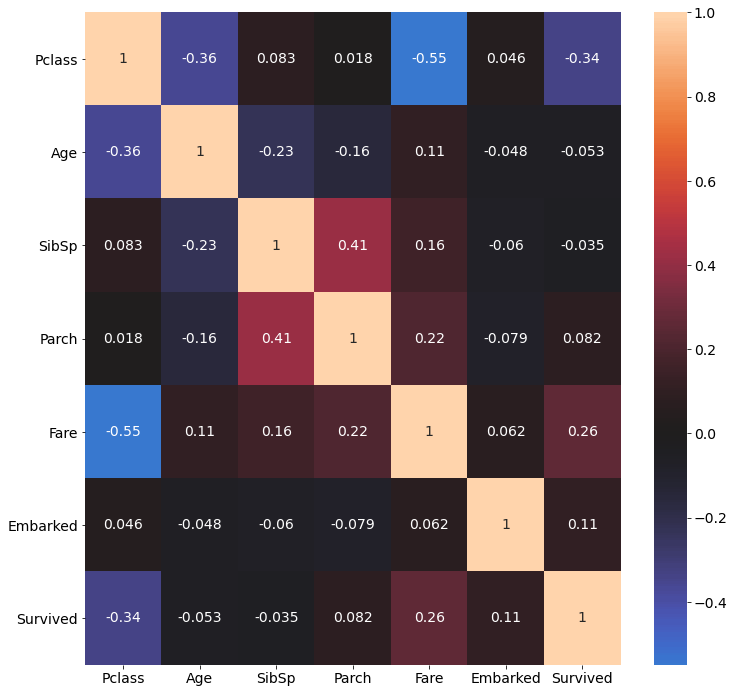

In [ ]:
plt.figure(figsize=(12, 12));
ax = sns.heatmap(train_df_.corr(), annot=True, center=0);
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0);

Since the Embarked column is somewhat correlated with the Survived column, so I think it makes sense that I transform the column as ordinal format.

Finally, the Sex column should't have ordinal characteristics, so we'll transform it to be one-hot encoding format.

In [ ]:
train_df_ = pd.get_dummies(train_df_)
test_df_ = pd.get_dummies(test_df_)

print('training data')
train_df_

print()
print('testing data')
test_df_

training data


,Pclass,Age,SibSp,Parch,Fare,Embarked,Survived,Sex_female,Sex_male
0,3,22.0,1,0,7.2500,1,0,0,1
1,1,38.0,1,0,71.2833,2,1,1,0
2,3,26.0,0,0,7.9250,1,1,1,0
3,1,35.0,1,0,53.1000,1,1,1,0
4,3,35.0,0,0,8.0500,1,0,0,1
...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,1,0,0,1
887,1,19.0,0,0,30.0000,1,1,1,0
888,3,24.0,1,2,23.4500,1,0,1,0
889,1,26.0,0,0,30.0000,2,1,0,1



testing data


,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,3,34.5,0,0,7.8292,3,0,1
1,3,47.0,1,0,7.0000,1,1,0
2,2,62.0,0,0,9.6875,3,0,1
3,3,27.0,0,0,8.6625,1,0,1
4,3,22.0,1,1,12.2875,1,1,0
...,...,...,...,...,...,...,...,...
413,3,24.0,0,0,8.0500,1,0,1
414,1,39.0,0,0,108.9000,2,1,0
415,3,38.5,0,0,7.2500,1,0,1
416,3,24.0,0,0,8.0500,1,0,1


Now we finally have data ready to reach to the most exciting modeling part!

## Modeling and Evaluation

After having some time doing data exploration, we are now going to build a model and evaluate its performance. The goal of building the first model is not to have the best performance; rather, we would want a baseline that can help us understand where and how we can do better. After all, we need to understand the problem-solving process should be iterative!

In order to build a machine learning model, we need several things prepared:
1. Model-ready data: it should be data after doing feature engineering, not just raw data
2. Machine learning algorithm: this is what modeling stands for
3. Evaluation Metric: in this problem, we are given to use "accuracy" as the metric

Since it's a binary classification task, I'll choose logistic regression as the baseline model!

### Baseline Model

**Model training using cross-validation**

We use [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) by preserving the percentage of samples for each class through random folds. Also, we use [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for cross-validation.

In [ ]:
features = test_df_.columns
label = ['Survived']

X = train_df_[features]
y = train_df_[label]

# random_state is for reproducibility
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
clf = LogisticRegression()
validation_results = cross_validate(clf, X, y, cv=sss, return_estimator=True)
estimators, test_scores = validation_results['estimator'], validation_results['test_score']

estimators
test_scores
print(f"mean accuracy: {np.mean(test_scores)}")

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 Log

array([0.78699552, 0.80269058, 0.81165919, 0.79147982, 0.79596413])

mean accuracy: 0.7977578475336323


Baseline model reaches ~79.7% accuracy

**Model prediction**

In [ ]:
survived = estimators[2].predict(test_df_) # we choose the estimator with the best training performance for prediction

**Save the Model Prediction Results to CSV**

In [ ]:
submission_dict = {
    'PassengerId': [*range(892, 1310)],
    'Survived': survived
}

# sanity check
assert len(submission_dict['PassengerId']) == len(submission_dict['Survived']), \
f"PasserngerId values({len(submission_dict['PassengerId'])}) length should equal to Survived values({len(submission_dict['Survived'])}) length"

# save the dict to csv file
with open('submission.csv', 'w') as csvfile:
    fieldnames = submission_dict.keys()
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for passenger_id, survived in zip(submission_dict['PassengerId'], submission_dict['Survived']):
        _ = writer.writerow({'PassengerId': passenger_id, 'Survived': survived}) #depress output

Although the training accuracy reaches ~79.7%, the testing accuracy only has 75.6%. There might be overfitting.

Now I am going to show you some pragmatic approaches to solve machine learning problems.

A pipeline allows you to chain multiple transformations of the data before you apply a final model.

Why we need to use the pipeline approach? Before I answer this question, I would like to ask you a question first. Did you notice that there is a problem in the cross-validation process above? OK, let me tell you the truth. In the cross-validation process, the input data comes from the output of feature engineering process. During the cross-validation process, we split the input data into 5 splits, and take one of the splits as the validation data. In theory, validation data shouldn't know any information about training data; however, before we run the cross-validation, we apply all training data to feature engineering process, thus we leak information to validation data later. This condition would make us too optimistic. So maybe this is one of the reasons for overfitting.

Now I am going to answer the first question I asked. There are several reasons that we use the pipeline approach:
1. It makes code cleaner and more configurable.
2. It prevents you from making mistakes like what I just mensioned above.(Because all processing happen inside the pipeline loop)

### ColumnTransformer and Pipeline

In [ ]:

label = ['Survived']
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

X_train = train_df[numeric_features + categorical_features]
y_train = train_df[label]

X_test = test_df[numeric_features + categorical_features]

for cat in categorical_features:
    X_train[cat].fillna('missing', inplace=True)
    X_test[cat].fillna('missing', inplace=True)

    
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
])
col_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Embarked']),
        ('ordinal', OrdinalEncoder(), ['Sex'])
    ],
    remainder='passthrough'                                 
)
categorical_transformer = Pipeline(steps=[
    ('col', col_transformer)
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression())
])

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
validation_results = cross_validate(model, X_train, y_train, cv=sss, return_estimator=True)
estimators, test_scores = validation_results['estimator'], validation_results['test_score']

test_scores
print(f"mean accuracy: {np.mean(test_scores)}")

array([0.77130045, 0.81165919, 0.81165919, 0.79372197, 0.79820628])

mean accuracy: 0.7973094170403587


The Machine learning process is iterative, and we always need to figure out ways to make prediction performance better based on the evaluation metric and I've already implemented the baseline model. 